# Decomposition - LightGBM v3.3

## Iris Dataset

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray.   The rows being the samples and the columns being:  Sepal Length, Sepal Width, Petal Length and Petal Width.

In [ ]:
# Import datasets
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb


In [ ]:
import pickle

In [ ]:
import graphviz
print(graphviz.__version__)

0.19.1


In [ ]:
print(lgb.__version__)

3.3.2


In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
X_test[0]

array([6.1, 2.8, 4.7, 1.2])

In [ ]:
y_test[0]

1

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    # 'metric': {'l2', 'l1'},
    'num_leaves': 5,   
    # 'learning_rate': 0.05,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    # 'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2,
                
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

Starting training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] Start training from score 1.030000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[2]	valid_0's l2: 0.477858
Saving model...
Starting predicting...
The RMSE of prediction is: 0.6912728541272807


In [ ]:
y_pred[0]

1.040090336294648

In [ ]:
leaf_preds = gbm.predict(X_train, pred_leaf=True)

In [ ]:
leaf_preds[0]

array([1, 1], dtype=int32)

In [ ]:
gbm.num_trees()

2

In [ ]:
gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 0.47785815885327665)])})

In [ ]:
# method trees_to_dataframe() is absent in version 2.2 
df_trees = gbm.trees_to_dataframe()

In [ ]:
df_trees

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-L0,0-S1,None,Column_2,46.9412,3.15,<=,left,None,1.030000,0,100
1,0,2,0-L0,None,None,0-S0,None,NaN,NaN,None,None,None,0.930125,32,32
2,0,2,0-S1,0-L1,0-L2,0-S0,Column_3,12.4647,1.75,<=,left,None,1.077000,68,68
3,0,3,0-L1,None,None,0-S1,None,NaN,NaN,None,None,None,1.037811,37,37
4,0,3,0-L2,None,None,0-S1,None,NaN,NaN,None,None,None,1.123774,31,31
5,1,1,1-S0,1-L0,1-S1,None,Column_2,38.0224,3.15,<=,left,None,0.000000,0,100
6,1,2,1-L0,None,None,1-S0,None,NaN,NaN,None,None,None,-0.089887,32,32
7,1,2,1-S1,1-L1,1-L2,1-S0,Column_3,10.2688,1.55,<=,left,None,0.042300,68,68
8,1,3,1-L1,None,None,1-S1,None,NaN,NaN,None,None,None,0.002280,33,33
9,1,3,1-L2,None,None,1-S1,None,NaN,NaN,None,None,None,0.080034,35,35


In [ ]:
df_trees.tree_index.nunique()

2

In [ ]:
df_trees.tree_index.unique()

array([0, 1])

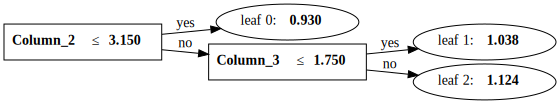

In [ ]:
lgb.create_tree_digraph(gbm, tree_index=0)

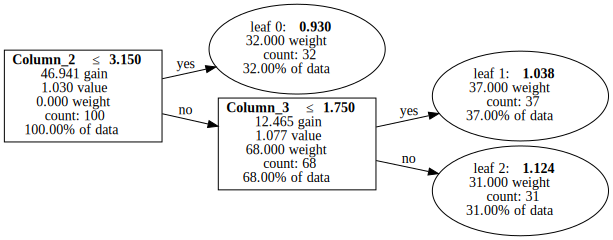

In [ ]:
lgb.create_tree_digraph(gbm, tree_index=0, show_info=[
    'split_gain', 'internal_value', 'internal_count',
   'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

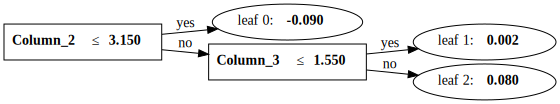

In [ ]:
lgb.create_tree_digraph(gbm, tree_index=1)

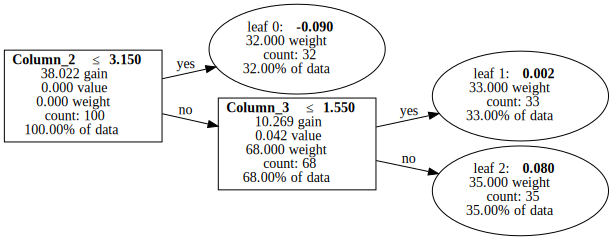

In [ ]:
lgb.create_tree_digraph(gbm, tree_index=1, show_info=[
    'split_gain', 'internal_value', 'internal_count',
   'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

#### Tree index:

Tree index refers to the tree we are looking at. In this case, we are looking at the tree with index 0. The first estimator.  

#### Node depth:

Indicates the level at which the partition takes place. For example, the first row refers to node depth 1, which is the first partition (node index 0-S0).

#### Node index, left child and right child, parent node:

Indicates the index of the node and the index of its “children”. In other words, the nodes to which the current node partitions to create. Parent node refers to the node the current node partitions from. Since 0-S0 is the first partition, it does not have a parent node.  

#### Split feature:

the feature the node partitions to create children nodes or leaves.

#### Split gain:

Measures split quality through.

#### Threshold:

Feature value used to decide whether the observation will advance to the node’s left children or right children.  

#### Missing direction:

Indicates to which child node the missing values go (based on the decision type).  

#### Value:

These are the raw predictions.   

#### Weight

Used in the split-gain calculation.

#### Count:

The count is the number of observations that fall inside the node.

In [ ]:
gbm.dump_model()

{'name': 'tree',
 'version': 'v3',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 3,
 'objective': 'regression',
 'average_output': False,
 'feature_names': ['Column_0', 'Column_1', 'Column_2', 'Column_3'],
 'monotone_constraints': [],
 'feature_infos': {'Column_0': {'min_value': 4.3,
   'max_value': 7.7,
   'values': []},
  'Column_1': {'min_value': 2, 'max_value': 4.2, 'values': []},
  'Column_2': {'min_value': 1.1, 'max_value': 6.7, 'values': []},
  'Column_3': {'min_value': 0.1, 'max_value': 2.5, 'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 3,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 2,
    'split_gain': 46.941200256347656,
    'threshold': 3.1500000000000004,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 1.03,
    'internal_weight': 0,
    'internal_count': 100,
    'left_child': {'leaf_index': 0,
     'leaf_va


#### `trees_to_dataframe()`

Parse the fitted model and return in an easy-to-read pandas DataFrame.

The returned DataFrame has the following columns.

**tree_index** : int64, which tree a node belongs to. 0-based, so a value of 6, for example, means “this node is in the 7th tree”.

**node_depth** : int64, how far a node is from the root of the tree. The root node has a value of 1, its direct children are 2, etc.

**node_index** : str, unique identifier for a node.

**left_child** : str, node_index of the child node to the left of a split. None for leaf nodes.

**right_child** : str, node_index of the child node to the right of a split. None for leaf nodes.

**parent_index** : str, node_index of this node’s parent. None for the root node.

**split_feature** : str, name of the feature used for splitting. None for leaf nodes.

**split_gain** : float64, gain from adding this split to the tree. NaN for leaf nodes.

**threshold** : float64, value of the feature used to decide which side of the split a record will go down. NaN for leaf nodes.

**decision_type** : str, logical operator describing how to compare a value to threshold. For example, split_feature = "Column_10", threshold = 15, decision_type = "<=" means that records where Column_10 <= 15 follow the left side of the split, otherwise follows the right side of the split. None for leaf nodes.

**missing_direction** : str, split direction that missing values should go to. None for leaf nodes.

**missing_type** : str, describes what types of values are treated as missing.

**value** : float64, predicted value for this leaf node, multiplied by the learning rate.

**weight** : float64 or int64, sum of hessian (second-order derivative of objective), summed over observations that fall in this node.

**count** : int64, number of records in the training data that fall into this node.

#### Returns

**result** – Returns a pandas DataFrame of the parsed model.
#### Return type

pandas DataFrame



In [ ]:

with open('gbm_dump_iris_2_tree.pickle', 'wb') as f:
    # Pickle using the highest protocol available.
    pickle.dump(gbm, f, pickle.HIGHEST_PROTOCOL)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de072003-a9db-4342-8067-19a4b45feff1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>